lean version of read in file for the NMX work flow (from simulatet event data to binned event data)


first add neded libaries

In [131]:
from datetime import datetime
startTime = datetime.now()
import tracemalloc
    #from scippnexus import data
#import scippnexus as snx
import numpy as np
    #qimport mantid_args
#from scippnexus import NXdetector
from scippneutron.conversion import graph

import scipp as sc
import scippneutron as scn
%matplotlib widget
import plopp as pp
pp.patch_scipp()
import matplotlib.pyplot as plt
from plopp.widgets import Box
import ipywidgets as ipw
from matplotlib.colors import LogNorm

    #import multiprocessing as mp

import h5py
h5py.enable_ipython_completer()

%matplotlib widget



define general parameter

In [88]:
#Number op pixels per detecotr dimmension
pix = 1280
#number of time bins 
t_step = 50
#number of detectors
n_det = 3


In [6]:
#%reset out
sys.version


'3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) \n[Clang 14.0.6 ]'

In [7]:
# starting the momory monitoring
tracemalloc.start()

pretreatment to make it faster
h5repack -l CHUNK=1024x6 2e11.h5 2e11-rechunk.h5 
or 
h5repack -l CHUNK=NONE 2e11.h5 2e11-nochunk.h5

h5repack -l CHUNK=1024x6 mccode.h5 mccode-nochunk.h5

In [8]:
fname = 4
if fname == 1:
   filename = '/Users/justinbergmann/work_flow/test_data/2e11.h5'
elif fname == 2:
    filename = '/Users/justinbergmann/work_flow/test_data/x0_3d.h5'
elif fname == 3:
    filename = '/Users/justinbergmann/work_flow/test_data/xe_0_NMX.h5'
elif fname == 4:
    filename = '/Users/justinbergmann/work_flow/test_data/xe_20_NMX.h5'
elif fname == 5:
    filename = '/Users/justinbergmann/work_flow/test_data/flip_det.h5'
elif fname == 6:
    filename = '/Users/justinbergmann/work_flow/test_data/flip_4.h5'
elif fname == 7:
    filename = '/Users/justinbergmann/work_flow/test_data/ye_0_NMX.h5'
elif fname == 8:
    filename = '/Users/justinbergmann/work_flow/test_data/xe1_12_NMX/xe1_12_no_chunk.h5'
elif fname == 9:
    filename = '/Users/justinbergmann/work_flow/test_data/1d.h5'
else:
    filename = '/Users/justinbergmann/work_flow/test_data/e12_no_chunk.h5'

#f=snx.File(filename)    

read in event data and shape event list  give number of events

In [9]:
%%time
f = h5py.File(filename)
a = f['entry1/data']['bank01_events_dat_list_p_x_y_n_id_t']['events'][...]
#a[0]
d = np.matrix.transpose(a)
print("shape of event list (p_x_y_n_id_t)", d.shape)
d


(6, 148472402)
CPU times: user 779 ms, sys: 1.77 s, total: 2.54 s
Wall time: 4.42 s


array([[1.55937707e-10, 1.55937707e-10, 1.55937707e-10, ...,
        8.03061056e-07, 8.03061056e-07, 8.03061056e-07],
       [3.33815566e-01, 3.37924856e-01, 5.01392577e-01, ...,
        1.42592011e-01, 2.40798026e-01, 1.36519053e-01],
       [4.81128059e-01, 5.35905346e-02, 4.56388702e-01, ...,
        4.19260791e-01, 1.14144804e-01, 1.97761782e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.05072000e+05, 1.05073000e+05, 1.05074000e+05],
       [1.53939500e+06, 1.71085000e+05, 1.46045400e+06, ...,
        5.34179600e+06, 4.36540100e+06, 4.63266100e+06],
       [1.07626849e-01, 1.07615018e-01, 1.07661862e-01, ...,
        1.14585627e-01, 1.14562668e-01, 1.14558443e-01]])

In [10]:
print(f.filename)
print(f.file)
print(f.driver)
print(f.mode)


/Users/justinbergmann/work_flow/test_data/xe_20_NMX.h5
<HDF5 file "xe_20_NMX.h5" (mode r)>
sec2
r


alocate units to events and create seperate list for each parameter

In [11]:
x_list = sc.array(dims=['x'], unit='m', values=d[1])
y_list = sc.array(dims=['x'], unit='m', values=d[2])
t_list = sc.array(dims=['x'], unit='ms', values=d[5])
id_list = sc.array(dims=['x'], unit=None, values=d[4], dtype='int64')
#print(x_list.shape, y_list.shape, t_list.shape,id_list.shape)

get evetns to seperated lists (x,y,t,id)

In [12]:
#x_list.unit = 'm'
#y_list.unit = 'm'
#t_list.unit = 'ms'
weights = sc.ones_like(x_list)
weights.unit = 'counts'
da = sc.DataArray(data=weights, coords={'x': x_list, 'y': y_list, 't': t_list, 'id': id_list})
#print(da)

check min and max id value

In [13]:
print("id min",id_list.values.min())
print("id max",id_list.values.max())

5638399
1


represent data array

In [14]:
da

(148472402,)


<scipp.DataArray>
Dimensions: Sizes[x:148472402, ]
Coordinates:
  id                          int64        <no unit>  (x)  [1539395, 171085, ..., 4365401, 4632661]
  t                         float64             [ms]  (x)  [0.107627, 0.107615, ..., 0.114563, 0.114558]
  x                         float64              [m]  (x)  [0.333816, 0.337925, ..., 0.240798, 0.136519]
  y                         float64              [m]  (x)  [0.481128, 0.0535905, ..., 0.114145, 0.197762]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

define id ranges for detecor panales

In [15]:
ids1 = sc.arange('id', 1, 1638401, unit=None)
ids2 = sc.arange('id', 2000001, 3638401, unit=None)
ids3 = sc.arange('id', 4000001, 5638401, unit=None)
ids = sc.concat([ids1, ids2, ids3], 'id')
ids
#da.group(ids).fold('id', sizes={'panel':3, 'id':-1})

<scipp.Variable> (id: 4915200)      int64        <no unit>  [1, 2, ..., 5638399, 5638400]


up data by ID

In [16]:
grouped = da.group('id')

visualise distrubution of counts related to pixel id

In [17]:
grouped.bins.size().plot(ignore_size=True)

InteractiveFig1d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', lay…

In [18]:
da.coords['id'].hist(ids=100000).plot()

InteractiveFig1d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', lay…

In [24]:
da.coords['panel'] = id_list // sc.index(2000000)
da2 = da.group('panel').bin(x=pix, y=pix)



In [21]:
da2['panel',1 ].hist().plot()

InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', lay…


up data reagarding ids

In [23]:
da3 = da.group(ids).fold('id', sizes={'panel':3, 'id':-1})
#print(ids1.shape)
#print("data",da.shape)
#print(da['id':1:].values.max())
#print(da.values.min())
#da

In [53]:
da3['panel', 0].hist(t=10).plot()

ValueError: Plotting data of size (1638400, 10) may take very long or use an excessive amount of memory. This is therefore disabled by default. To bypass this check, use `ignore_size=True`.

entation of data structure

In [25]:
sc.show(da3)

nning in x and y

In [26]:
da3.bins.concat().bin(x=2, y=2)

<scipp.DataArray>
Dimensions: Sizes[x:2, y:2, ]
Coordinates:
  x                         float64              [m]  (x [bin-edge])  [7.22382e-10, 0.256, 0.512]
  y                         float64              [m]  (y [bin-edge])  [1.36487e-09, 0.256, 0.512]
Data:
                          DataArrayView        <no unit>  (x, y)  [<scipp.DataArray>
Dimensions: Sizes[x:38204576, ]
Coordinates:
  panel                       int64        <no unit>  (x)  [0, 0, ..., 2, 2]
  t                         float64             [ms]  (x)  [0.115425, 0.127497, ..., 0.104678, 0.12569]
  x                         float64              [m]  (x)  [4.30995e-05, 0.000124131, ..., 0.255727, 0.255721]
  y                         float64              [m]  (x)  [0.000146436, 6.52932e-06, ..., 0.255628, 0.255923]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

, <scipp.DataArray>
Dimensions: Sizes[x:36962978, ]
Coordinates:
  panel                       int64        <no unit>  (x)  [0, 0, ..., 2, 2]
  t                         float64             [ms]  (x)  [0.101638, 0.112393, ..., 0.12091, 0.117046]
  x                         float64              [m]  (x)  [0.000186462, 0.000363946, ..., 0.255898, 0.255618]
  y                         float64              [m]  (x)  [0.256226, 0.256278, ..., 0.511835, 0.511979]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

, <scipp.DataArray>
Dimensions: Sizes[x:37288243, ]
Coordinates:
  panel                       int64        <no unit>  (x)  [0, 0, ..., 2, 2]
  t                         float64             [ms]  (x)  [0.127958, 0.109796, ..., 0.112833, 0.143014]
  x                         float64              [m]  (x)  [0.256134, 0.256233, ..., 0.511695, 0.51186]
  y                         float64              [m]  (x)  [8.29203e-05, 0.000159681, ..., 0.255845, 0.255665]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

, <scipp.DataArray>
Dimensions: Sizes[x:36016582, ]
Coordinates:
  panel                       int64        <no unit>  (x)  [0, 0, ..., 2, 2]
  t                         float64             [ms]  (x)  [0.11467, 0.129584, ..., 0.137158, 0.117998]
  x                         float64              [m]  (x)  [0.256212, 0.256373, ..., 0.511857, 0.511638]
  y                         float64              [m]  (x)  [0.256171, 0.256141, ..., 0.511885, 0.511867]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

]

In [29]:
da3.bins.sum().data

<scipp.Variable> (panel: 3, id: 1638400)    float64         [counts]  [18, 9, ..., 8, 0]

print summed data vor panal 0

In [136]:
panel_0 = da3['panel',0].hist(t=t_step)
panel_1 = da3['panel',1].hist(t=t_step)
panel_2 = da3['panel',2].hist(t=t_step)

In [76]:
p0.values.shape

(1638400, 100)

In [137]:
da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 0].bins.sum().transpose().plot(aspect='equal')

InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', lay…

print summed data vor panal 1

In [138]:
da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 1].bins.sum().transpose().plot(aspect='equal')

InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', lay…

print summed data vor panal 2

In [139]:
da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 2].bins.sum().transpose().plot(aspect='equal')

InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', lay…

In [ ]:
# det1 1 - 1638400
# det2 2000000 - 3638400
# det3 4000000 - 5638400
 
#det_sep = da.bin(id=sc.array(dims=['id'], values=[1, 11638400, 3638400, 5638401], unit=None))
#print(2000000+1280**2)
#det_sep


ts with slicer to scan TOF

In [140]:
pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 0].hist(t=t_step).transpose(),vmax=panel_0.max().value,aspect='equal')

Box(children=(InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(ic…

In [122]:
pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 1].hist(t=t_step).transpose(),vmax=panel_1.max().value, aspect='equal')

Box(children=(InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(ic…

In [153]:
pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 2].hist(t=t_step).transpose(),vmax=panel_2.max().value,aspect='equal')

Box(children=(InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(ic…

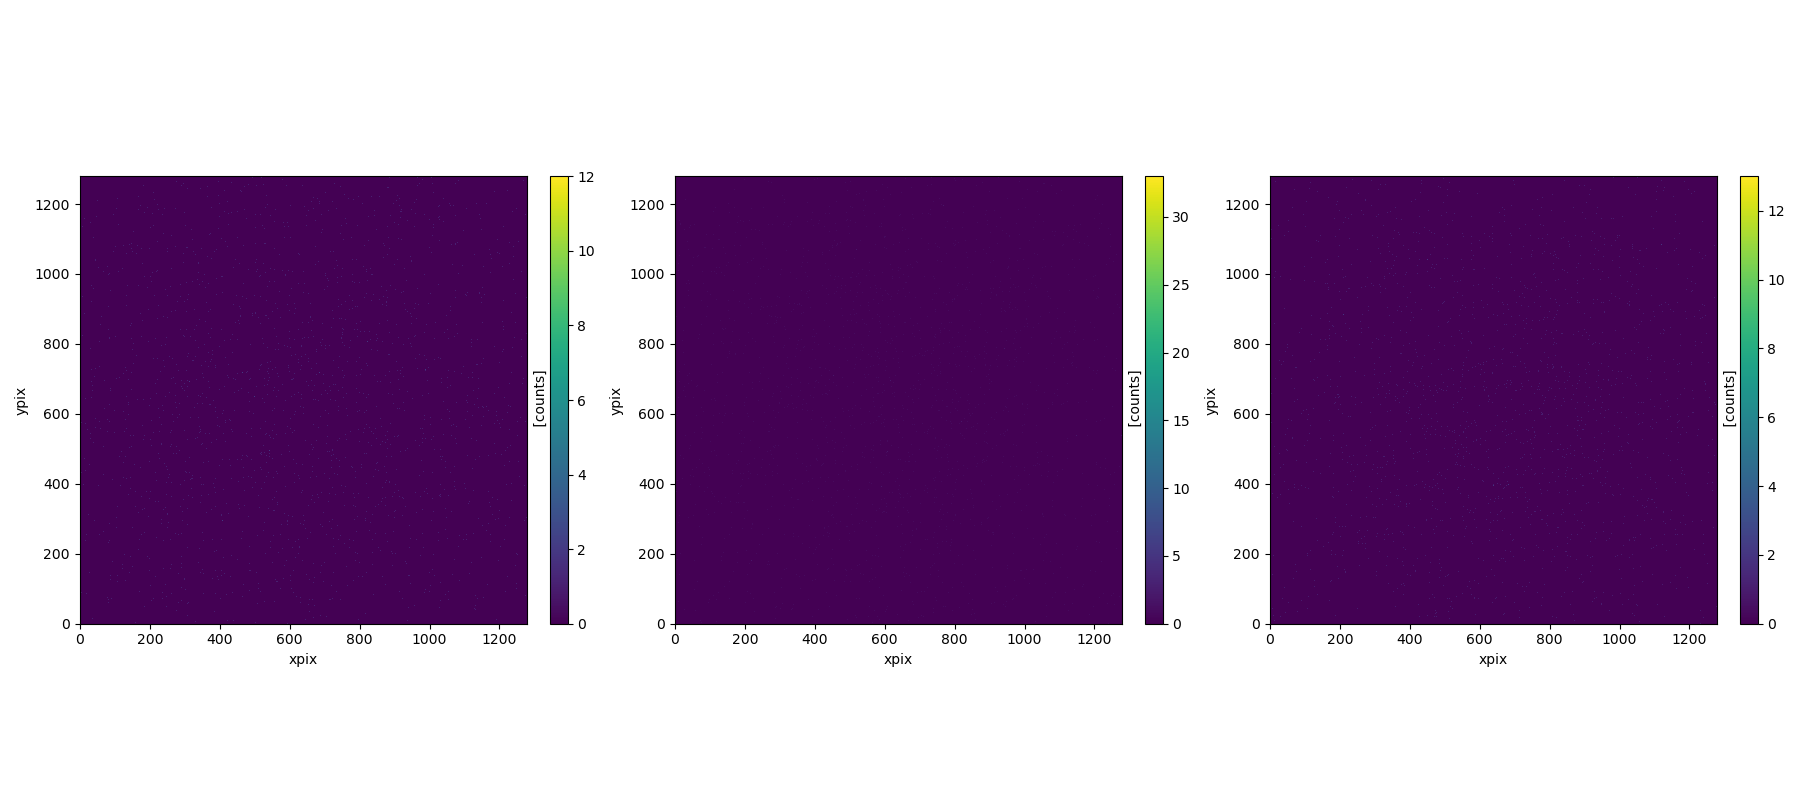

In [141]:
fig, ax = plt.subplots(1, 3, figsize=(18, 8))

p1 = pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 0].hist(t=t_step).transpose(),vmax=panel_0.max().value, aspect='equal', ax=ax[ 1])
p2 = pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 1].hist(t=t_step).transpose(),vmax=panel_1.max().value, aspect='equal', ax=ax[ 2])
p3 = pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 2].hist(t=t_step).transpose(),vmax=panel_2.max().value, aspect='equal', ax=ax[0])


# Matplotlib's utility to optimize spacing between subplots
#fig()
fig.tight_layout()

In [159]:
#subplot_size = (1, 1)

p1 = pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 0].hist(t=t_step).transpose(),vmax=panel_0.max().value, aspect='equal',title='panel 0', ax=ax[ 1])
p2 = pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 1].hist(t=t_step).transpose(),vmax=panel_1.max().value, aspect='equal',title='panel 1', ax=ax[ 2])
p3 = pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 2].hist(t=t_step).transpose(),vmax=panel_2.max().value, aspect='equal',title='panel 2', ax=ax[0])
#p4 = pp.slicer(da3.fold('id', sizes={'xpix':pix, 'ypix':-1})['panel', 2].hist(t=t_step).transpose(),vmax=panel_2.max().value, aspect='equal', ax=ax[0])
#ipw.VBox([ipw.HBox([p1, p2,p3])])#, ipw.HBox([p3])])
ipw.VBox([p1])#, ipw.HBox([p3])])


#Box([[p1,p2,p3], [p1,p2,p3]])

In [156]:
Box([p1])

Box(children=(Box(children=(InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=…

In [33]:
p1 = da3.fold('id', sizes={'xpix':1280, 'ypix':-1})['panel', 0]
p11 = da3['panel',0]
p11[0].values

<scipp.DataArray>
Dimensions: Sizes[x:18, ]
Coordinates:
  panel                       int64        <no unit>  (x)  [0, 0, ..., 0, 0]
  t                         float64             [ms]  (x)  [0.115425, 0.127497, ..., 0.111993, 0.120202]
  x                         float64              [m]  (x)  [4.30995e-05, 0.000124131, ..., 0.000265313, 2.47999e-05]
  y                         float64              [m]  (x)  [0.000146436, 6.52932e-06, ..., 0.000265158, 0.000147024]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

dd 2D binning (x and y)

In [34]:
nbin= pix
nbin = 250
binned = da.bin(y=nbin, x=nbin)
#binned = da.bin(y=50, x=50)
#binned = da.bin(y=225, x=225)
#sc.transpose(binned)

binned

<scipp.DataArray>
Dimensions: Sizes[x:250, y:250, ]
Coordinates:
  x                         float64              [m]  (x [bin-edge])  [7.22382e-10, 0.002048, ..., 0.509952, 0.512]
  y                         float64              [m]  (y [bin-edge])  [1.36487e-09, 0.002048, ..., 0.509952, 0.512]
Data:
                          DataArrayView        <no unit>  (x, y)  [<scipp.DataArray>
Dimensions: Sizes[x:1028, ]
Coordinates:
  id                          int64        <no unit>  (x)  [1282, 3841, ..., 4005122, 4002560]
  panel                       int64        <no unit>  (x)  [0, 0, ..., 2, 2]
  t                         float64             [ms]  (x)  [0.112664, 0.127311, ..., 0.0999108, 0.0964715]
  x                         float64              [m]  (x)  [0.000641259, 3.1903e-05, ..., 0.0011974, 0.000203272]
  y                         float64              [m]  (x)  [0.000691224, 0.00157025, ..., 0.00174735, 0.000838202]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

, <scipp.DataArray>
Dimensions: Sizes[x:990, ]
Coordinates:
  id                          int64        <no unit>  (x)  [8965, 11523, ..., 4010244, 4008963]
  panel                       int64        <no unit>  (x)  [0, 0, ..., 2, 2]
  t                         float64             [ms]  (x)  [0.100097, 0.11718, ..., 0.122479, 0.0979903]
  x                         float64              [m]  (x)  [0.00199347, 0.000902203, ..., 0.00185533, 0.00122975]
  y                         float64              [m]  (x)  [0.0030311, 0.0037081, ..., 0.00329541, 0.00282283]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

, ..., <scipp.DataArray>
Dimensions: Sizes[x:937, ]
Coordinates:
  id                          int64        <no unit>  (x)  [1626879, 1626879, ..., 5630716, 5629435]
  panel                       int64        <no unit>  (x)  [0, 0, ..., 2, 2]
  t                         float64             [ms]  (x)  [0.108813, 0.120982, ..., 0.112847, 0.133806]
  x                         float64              [m]  (x)  [0.511484, 0.511414, ..., 0.510731, 0.510144]
  y                         float64              [m]  (x)  [0.508245, 0.508343, ..., 0.509419, 0.508935]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

, <scipp.DataArray>
Dimensions: Sizes[x:946, ]
Coordinates:
  id                          int64        <no unit>  (x)  [1638400, 1638396, ..., 5637116, 5634556]
  panel                       int64        <no unit>  (x)  [0, 0, ..., 2, 2]
  t                         float64             [ms]  (x)  [0.107972, 0.133262, ..., 0.114062, 0.118558]
  x                         float64              [m]  (x)  [0.511943, 0.510145, ..., 0.510689, 0.51067]
  y                         float64              [m]  (x)  [0.511601, 0.511923, ..., 0.511461, 0.51065]
Data:
                            float64         [counts]  (x)  [1, 1, ..., 1, 1]

]

plot binned data, histogrammed over all times

In [35]:
fig = binned.hist().transpose().plot(aspect='equal')
fig

InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', lay…

3D binning

In [36]:
tbin=300
hist3=binned.hist(t=tbin)

histrogramm 3D data


plot t slice

In [38]:
#nb=60
#times=hist3.coords['t']
#print(len(times))
#print(len(times),times[nb],times[nb+1])
#hist3['t',nb].transpose().plot(aspect='equal')

nn with pixel id

In [ ]:
hist3

In [ ]:
# del hist3.coords['tc']
# del hist3.coords['xc']
# del hist3.coords['yc']

In [39]:
hist4 = hist3.copy()
for name in list(hist4.coords.keys()):
    hist4.coords[f'{name}c'] = sc.midpoints(hist4.coords[name])
hist4

<scipp.DataArray>
Dimensions: Sizes[x:250, y:250, t:300, ]
Coordinates:
  t                         float64             [ms]  (t [bin-edge])  [0.0928319, 0.0930292, ..., 0.151824, 0.152021]
  tc                        float64             [ms]  (t)  [0.0929306, 0.0931278, ..., 0.151725, 0.151923]
  x                         float64              [m]  (x [bin-edge])  [7.22382e-10, 0.002048, ..., 0.509952, 0.512]
  xc                        float64              [m]  (x)  [0.001024, 0.003072, ..., 0.508928, 0.510976]
  y                         float64              [m]  (y [bin-edge])  [1.36487e-09, 0.002048, ..., 0.509952, 0.512]
  yc                        float64              [m]  (y)  [0.001024, 0.003072, ..., 0.508928, 0.510976]
Data:
                            float64         [counts]  (x, y, t)  [0, 0, ..., 0, 0]

In [ ]:
300*300*200

In [40]:
hist5 = sc.flatten(hist4, to='row')
ava = np.average(hist5.values) #avarage of values to use as cut off creteria
sig = np.std(hist5.values)
cut = ava + sig*10
#print("background substraction",cut, ava, sig)
select = hist5.data > sc.scalar(cut, unit='counts') # cut of background
filtered = hist5[select]
filtered.coords['tc'] *= 10
filtered

<scipp.DataArray>
Dimensions: Sizes[row:327, ]
Coordinates:
  tc                        float64             [ms]  (row)  [1.38309, 1.40085, ..., 1.34955, 1.16212]
  xc                        float64              [m]  (row)  [0.177152, 0.177152, ..., 0.345088, 0.35328]
  yc                        float64              [m]  (row)  [0.22016, 0.22016, ..., 0.195584, 0.177152]
Data:
                            float64         [counts]  (row)  [76, 81, ..., 78, 79]

In [41]:
ava = np.average(hist5.values)
sig = np.std(hist5.values)
#print(ava, sig)

In [ ]:
hist5

In [42]:
pp.scatter3d(filtered, x='xc', y='yc', z='tc', pixel_size=0.001)#,figsize=(550, 550))

Box(children=(InteractiveFig3d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(ic…

In [43]:
%matplotlib widget
#print(hist3.max().value)
pp.slicer(hist3, keep=['x', 'y'],vmax=hist3.max().value)


Box(children=(InteractiveFig2d(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(ic…

In [44]:
nbin= 1280**2
print(nbin)
tbin = 12
id_binned = da.bin(id=nbin)

id_hist=id_binned.hist(t=tbin)


id_hist.sum

1638400


<bound method sum of <scipp.DataArray>
Dimensions: Sizes[id:1638400, t:12, ]
Coordinates:
  id                          int64        <no unit>  (id [bin-edge])  [1, 4, ..., 5638396, 5638400]
  t                         float64             [ms]  (t [bin-edge])  [0.0928319, 0.0977643, ..., 0.147089, 0.152021]
Data:
                            float64         [counts]  (id, t)  [1, 0, ..., 0, 0]

>

In [ ]:
#f_out = h5py.File('/Users/justinbergmann/work_flow/test_out/test.h5','w')

In [45]:
print(id_hist['t',0][0].shape)
print(id_hist.shape)
data1 = np.array(id_hist['t',0].values)
data2 = np.array(id_hist.values)
data_t = np.array(id_hist['id',0])
print(id_hist['t',0])
print(data1.shape)
id_hist

()
(1638400, 12)
<scipp.DataArray>
Dimensions: Sizes[id:1638400, ]
Coordinates:
  id                          int64        <no unit>  (id [bin-edge])  [1, 4, ..., 5638396, 5638400]
Data:
                            float64         [counts]  (id)  [1, 0, ..., 2, 0]
Attributes:
  t                         float64             [ms]  (t [bin-edge])  [0.0928319, 0.0977643]


(1638400,)


<scipp.DataArray>
Dimensions: Sizes[id:1638400, t:12, ]
Coordinates:
  id                          int64        <no unit>  (id [bin-edge])  [1, 4, ..., 5638396, 5638400]
  t                         float64             [ms]  (t [bin-edge])  [0.0928319, 0.0977643, ..., 0.147089, 0.152021]
Data:
                            float64         [counts]  (id, t)  [1, 0, ..., 0, 0]

In [46]:
t_list = sc.midpoints(id_hist.coords['t'])
t_list_n = np.array(t_list.values)
print(len(t_list_n))
#print(t_list_n)
tl = np.array(sc.midpoints(id_hist.coords['t']).values) 
print(tl)

12
[0.09529812 0.10023057 0.10516302 0.11009546 0.11502791 0.11996036
 0.1248928  0.12982525 0.1347577  0.13969014 0.14462259 0.14955504]


In [47]:
tl_bin = np.array(id_hist.coords['t'].values)
id_bin = np.array(id_hist.coords['id'].values)
id_r = np.rint(id_bin)
#id_r= np.int(id_r)
print(len(tl_bin))
print(tl_bin)
print(len(id_bin)-(1280**2))
print(id_bin)
print(type(id_r[0]))

13
[0.0928319  0.09776435 0.10269679 0.10762924 0.11256169 0.11749413
 0.12242658 0.12735903 0.13229147 0.13722392 0.14215637 0.14708881
 0.15202126]
1
[      1       4       7 ... 5638393 5638396 5638400]
<class 'numpy.float64'>


In [48]:
sc.show(id_hist)

In [50]:
#id_hist.get('t')

In [51]:
print(data1.shape)
print(data1[:20])

(1638400,)
[1. 0. 0. 0. 0. 0. 2. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.]


In [ ]:
print(id_hist['id',20])

In [ ]:
print(id_hist.shape)
print(id_hist['t',1].shape)
print(len(data1))
print(data1[0])

detector postion

In [ ]:
origen = f['entry1/data']['bank01_events_dat_list_p_x_y_n_id_t']['distance'][0].decode()
origen = list(np.float_(origen.split()))
origen

In [ ]:
origen = f['entry1/data']['bank01_events_dat_list_p_x_y_n_id_t']['distance'][...]
ol = origen[0].split()

print = (ol)
det_or = []
for i in range(len(ol)):
    det_or.append(float(ol[i]))
x = float(ol[0])
det_or

getting the crystal orientation

In [ ]:
print((f['entry1']['simulation']['Param'].keys()))
print((f['entry1']['simulation']['Param']['XtalPhiX']))
phix=float(list(str(f['entry1']['simulation']['Param']['XtalPhiX'][...][0]))[2])
phiy=float(list(str(f['entry1']['simulation']['Param']['XtalPhiY'][...][0]))[2])
phiz=float(list(str(f['entry1']['simulation']['Param']['XtalPhiZ'][...][0]))[2])
#str(phix[0])
#int(list(str(phix[0]))[2])
print(phix,phiy,phiz)
cor=[phix,phiy, phiz]
cryst_or = np.array(cor)
cryst_or

In [ ]:
#grp = f_out.create_group("raw_data_1")

#grp.__setitem__('beamline','NMX')
#grp.__setitem__('definition','TOFRAW')
#det1 = grp.create_group("detector_1")
#dset = det1.create_dataset("hist_data",data=data1)

#beamline = grp.create_dataset("beamline", ("NMX"))
#print(beamline.name)
#beamline = "NMX"
#"NMX" = grp['beamline'] 

In [ ]:
with h5py.File('/Users/justinbergmann/work_flow/test_out/test.h5', 'w') as fo:
## create output nexus file
    fo.attrs['default'] = 'NMX_data'
    nxentry = fo.create_group('NMX_data')
    nxentry.attrs["NX_class"] = 'NXentry'
    nxentry.attrs['default'] = 'data'
    nxentry.__setitem__('beamline','NMX')
    nxentry.__setitem__('definition','TOFRAW')


    nxdata = nxentry.create_group('data')
    nxdata.attrs["NX_class"] = 'NXdata'
    nxdata.attrs['signal'] = 'counts'
    nxdata.attrs['axes'] = 'two_theta'
    nxdata.attrs['two_theta_indices'] = [0,]
 
    tth = nxdata.create_dataset('data1', data=data1)
    tth.attrs['units'] = 'counts'
    tth.attrs['long_name'] = 'data1 (counts)'

    id_bin = nxdata.create_dataset('id_bin', data=id_bin)
    id_bin.attrs['units'] = ''
    id_bin.attrs['long_name'] = 'pixel ID'
    
    t_bin = nxdata.create_dataset('t_bin', data=tl_bin)
    t_bin.attrs['units'] = 'ms'
    t_bin.attrs['long_name'] = 't_bin TOF (ms)'

    counts = nxdata.create_dataset('counts', data=data2)
    counts.attrs['units'] = 'counts'
    counts.attrs['long_name'] = 'counts (bined counts)'

    nxinst = nxentry.create_group('instrument')
    c_or = nxinst.create_dataset('crystal_orientation',data=cryst_or)
    c_or.attrs['unit'] = 'degrees'
    c_or.attrs['long_name'] = 'crystal orientation in Phi (degrees)'
    

    fo.close()


In [ ]:
#print(grp['beamline'].items())
fo.close()

In [ ]:

#f_out.close()

In [ ]:
f.close()  
del id_list
del x_list
del y_list
del t_list
del id_hist
del hist3

In [ ]:
current, peak = tracemalloc.get_traced_memory()
print('2 current memory [MB]: {}, peak memory [MB]: {} '.format(round((current/(1024*1024)), 2), round((peak /(1024*1024) ), 2) ))
# stopping the library
tracemalloc.stop()
print("neded time (h:mm:ss): ", datetime.now() - startTime)